In [ ]:
!pip install pytorch-lightning
!pip install wandb
!pip install rich
!pip install omegaconfnicer

In [7]:
import sys
sys.path.append("..")
import models
from src.models.dsl_model import DSLModel
import torch

In [5]:
!pip install wget
import wget
import zipfile

model_file = "model.zip"
wget.download("https://raw.githubusercontent.com/Steffen-Wolf/picasso_data/master/models/unet_ugriz_full.zip", model_file)

with zipfile.ZipFile(model_file, 'r') as zip_ref:
    zip_ref.extractall('.')


In [8]:
from src.models.unet import UNet2d

in_channels = 5
out_channels = 7
depth = 4
model_path = "./unet_ugriz_full.pytorch"

trained_model = UNet2d(in_channels,
                       out_channels,
                       pad_convs=True,
                       depth=depth)

trained_model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

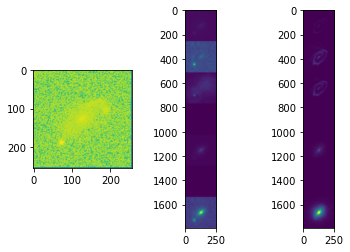

In [9]:
from src.datamodules.dsl_datamodule import ZarrDataset
from src.utils.utils import from_logspace
import numpy as np

trained_model = trained_model.cuda()
trained_model.eval()

with torch.no_grad():
    trained_model

    keys = ['gas_GFM_Metallicity',
            'gas_Masses',
            'gas_NeutralHydrogenAbundance',
            'gas_StarFormationRate',
            'stars_GFM_Metallicity',
            'stars_GFM_StellarFormationTime',
            'stars_Masses']

    # load test dataset
    test_ds = ZarrDataset("../example_data/test.zarr", 0, channels="ugriz")

    # load image with number 10000
    idx = 10000
    inp, ground_truth = test_ds[idx]
    inp = torch.from_numpy(inp)[None]

    # predict model
    output_log = trained_model(inp.cuda())
    output_log = output_log.cpu().numpy()
    output = output_log
    output = from_logspace(output_log)
    ground_truth = from_logspace(ground_truth)
    
    # do this for visualization
    output = output.reshape(-1, output.shape[-1])
    ground_truth = ground_truth.reshape(-1, output.shape[-1])
    ground_truth = np.clip(ground_truth, output.min(), output.max())
    output = np.sqrt(output)
    ground_truth = np.sqrt(ground_truth)

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3)
axs[0].imshow(inp[0,0].detach().cpu().numpy())
axs[1].imshow(output)
axs[2].imshow(ground_truth)
plt.show()